In [1]:
import math
import matplotlib
import numpy as np
import pandas as pd
import seaborn as sns
import time

from datetime import date
from matplotlib import pyplot as plt
from pylab import rcParams
from sklearn.metrics import mean_squared_error
from sklearn.preprocessing import StandardScaler
from tqdm import tqdm_notebook

%matplotlib inline

#### Input params ##################
stk_path = "../../data/zz500.csv"
# stk_path = "../../data/GSPC.csv"

test_size = 0.2                # proportion of dataset to be used as test set
cv_size = 0.2                  # proportion of dataset to be used as cross-validation set
N = 3                         # for feature at day t, we use lags from t-1, t-2, ..., t-N as features

n_estimators = 100             # Number of boosted trees to fit. default = 100
max_depth = 3                  # Maximum tree depth for base learners. default = 3
learning_rate = 0.1            # Boosting learning rate (xgb’s “eta”). default = 0.1
min_child_weight = 1           # Minimum sum of instance weight(hessian) needed in a child. default = 1
subsample = 1                  # Subsample ratio of the training instance. default = 1
colsample_bytree = 1           # Subsample ratio of columns when constructing each tree. default = 1
colsample_bylevel = 1          # Subsample ratio of columns for each split, in each level. default = 1
gamma = 0                      # Minimum loss reduction required to make a further partition on a leaf node of the tree. default=0

model_seed = 100

fontsize = 14
ticklabelsize = 14
####################################

# Common functions

In [2]:
from xgboost import XGBRegressor

def get_mov_avg_std(df, col, N):
    """
    Given a dataframe, get mean and std dev at timestep t using values from t-1, t-2, ..., t-N.
    Inputs
        df         : dataframe. Can be of any length.
        col        : name of the column you want to calculate mean and std dev
        N          : get mean and std dev at timestep t using values from t-1, t-2, ..., t-N
    Outputs
        df_out     : same as df but with additional column containing mean and std dev
    """
    mean_list = df[col].rolling(window = N, min_periods=1).mean() # len(mean_list) = len(df)
    std_list = df[col].rolling(window = N, min_periods=1).std()   # first value will be NaN, because normalized by N-1
    
    # Add one timestep to the predictions
    mean_list = np.concatenate((np.array([np.nan]), np.array(mean_list[:-1])))
    std_list = np.concatenate((np.array([np.nan]), np.array(std_list[:-1])))
    
    # Append mean_list to df
    df_out = df.copy()
    df_out[col + '_mean'] = mean_list
    df_out[col + '_std'] = std_list
    
    return df_out

def scale_row(row, feat_mean, feat_std):
    """
    Given a pandas series in row, scale it to have 0 mean and var 1 using feat_mean and feat_std
    Inputs
        row      : pandas series. Need to scale this.
        feat_mean: mean  
        feat_std : standard deviation
    Outputs
        row_scaled : pandas series with same length as row, but scaled
    """
    # If feat_std = 0 (this happens if adj_close doesn't change over N days), 
    # set it to a small number to avoid division by zero
    feat_std = 0.001 if feat_std == 0 else feat_std
    
    row_scaled = (row-feat_mean) / feat_std
    
    return row_scaled

def get_mape(y_true, y_pred): 
    """
    Compute mean absolute percentage error (MAPE)
    """
    y_true, y_pred = np.array(y_true), np.array(y_pred)
    return np.mean(np.abs((y_true - y_pred) / y_true)) * 100


# Load data

In [3]:
df = pd.read_csv(stk_path, sep = ",")

# Convert Date column to datetime
df.loc[:, 'Date'] = pd.to_datetime(df['Date'],format='%Y-%m-%d')

# Change all column headings to be lower case, and remove spacing
df.columns = [str(x).lower().replace(' ', '_') for x in df.columns]

# Get month of each sample
df['month'] = df['date'].dt.month

# Sort by datetime
df.sort_values(by='date', inplace=True, ascending=True)

df.head()

,date,close,high,open,low,volume,adj_close,month
2665,2007-01-04,1723.69,1748.091,1738.929,1719.498,3.212987e+09,1723.69,1
2666,2007-01-05,1770.47,1770.483,1719.283,1712.737,2.954547e+09,1770.47,1
1723,2007-01-08,1851.96,1851.964,1773.023,1773.023,3.971932e+09,1851.96,1
1724,2007-01-09,1891.87,1893.723,1855.347,1853.901,4.284591e+09,1891.87,1
2667,2007-01-10,1940.83,1940.832,1896.711,1884.619,4.540634e+09,1940.83,1


Text(0, 0.5, 'USD')

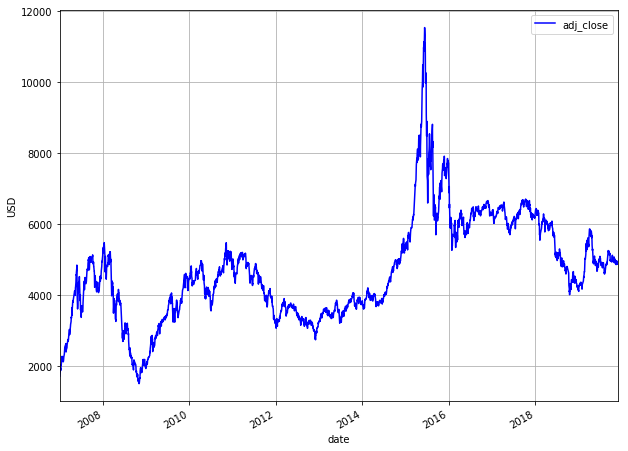

In [4]:
# Plot adjusted close over time
rcParams['figure.figsize'] = 10, 8 # width 10, height 8

ax = df.plot(x='date', y='adj_close', style='b-', grid=True)
ax.set_xlabel("date")
ax.set_ylabel("USD")

# Feature Engineering

We will generate the following features:
* Mean 'adj_close' of each month
* Difference between high and low of each day
* Difference between open and close of each day
* Mean volume of each month

In [5]:
# Get difference between high and low of each day
df['range_hl'] = df['high'] - df['low']
df.drop(['high', 'low'], axis=1, inplace=True)

# Get difference between open and close of each day
df['range_oc'] = df['open'] - df['close']
df.drop(['open', 'close'], axis=1, inplace=True)

df.head()

,date,volume,adj_close,month,range_hl,range_oc
2665,2007-01-04,3.212987e+09,1723.69,1,28.593,15.239
2666,2007-01-05,2.954547e+09,1770.47,1,57.746,-51.187
1723,2007-01-08,3.971932e+09,1851.96,1,78.941,-78.937
1724,2007-01-09,4.284591e+09,1891.87,1,39.822,-36.523
2667,2007-01-10,4.540634e+09,1940.83,1,56.213,-44.119


Now we use lags up to N number of days to use as features.

In [6]:
# Add a column 'order_day' to indicate the order of the rows by date
df['order_day'] = [x for x in list(range(len(df)))]

# merging_keys
merging_keys = ['order_day']

# List of columns that we will use to create lags
lag_cols = ['adj_close', 'range_hl', 'range_oc', 'volume']
lag_cols

['adj_close', 'range_hl', 'range_oc', 'volume']

In [7]:
shift_range = [x+1 for x in range(N)]

for shift in tqdm_notebook(shift_range):
    train_shift = df[merging_keys + lag_cols].copy()
    
    # E.g. order_day of 0 becomes 1, for shift = 1.
    # So when this is merged with order_day of 1 in df, this will represent lag of 1.
    train_shift['order_day'] = train_shift['order_day'] + shift
    
    foo = lambda x: '{}_lag_{}'.format(x, shift) if x in lag_cols else x
    train_shift = train_shift.rename(columns=foo)

    df = pd.merge(df, train_shift, on=merging_keys, how='left') #.fillna(0)
    
del train_shift

# Remove the first N rows which contain NaNs
df = df[N:]
    
df.head()

/home/jerry/workshop/virtualenv/alpha-mind/lib/python3.6/site-packages/ipykernel_launcher.py:3: TqdmDeprecationWarning: This function will be removed in tqdm==5.0.0
Please use `tqdm.notebook.tqdm` instead of `tqdm.tqdm_notebook`
  This is separate from the ipykernel package so we can avoid doing imports until


,date,volume,adj_close,month,range_hl,range_oc,order_day,adj_close_lag_1,range_hl_lag_1,range_oc_lag_1,volume_lag_1,adj_close_lag_2,range_hl_lag_2,range_oc_lag_2,volume_lag_2,adj_close_lag_3,range_hl_lag_3,range_oc_lag_3,volume_lag_3
3,2007-01-09,4.284591e+09,1891.870,1,39.822,-36.523,3,1851.96,78.941,-78.937,3.971932e+09,1770.47,57.746,-51.187,2.954547e+09,1723.69,28.593,15.239,3.212987e+09
4,2007-01-10,4.540634e+09,1940.830,1,56.213,-44.119,4,1891.87,39.822,-36.523,4.284591e+09,1851.96,78.941,-78.937,3.971932e+09,1770.47,57.746,-51.187,2.954547e+09
5,2007-01-11,5.388346e+09,1952.230,1,69.665,-5.729,5,1940.83,56.213,-44.119,4.540634e+09,1891.87,39.822,-36.523,4.284591e+09,1851.96,78.941,-78.937,3.971932e+09
6,2007-01-12,4.408009e+09,1881.750,1,93.275,59.595,6,1952.23,69.665,-5.729,5.388346e+09,1940.83,56.213,-44.119,4.540634e+09,1891.87,39.822,-36.523,4.284591e+09
7,2007-01-15,3.881263e+09,1986.539,1,105.072,-105.072,7,1881.75,93.275,59.595,4.408009e+09,1952.23,69.665,-5.729,5.388346e+09,1940.83,56.213,-44.119,4.540634e+09


In [8]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 3130 entries, 3 to 3132
Data columns (total 19 columns):
date               3130 non-null datetime64[ns]
volume             3130 non-null float64
adj_close          3130 non-null float64
month              3130 non-null int64
range_hl           3130 non-null float64
range_oc           3130 non-null float64
order_day          3130 non-null int64
adj_close_lag_1    3130 non-null float64
range_hl_lag_1     3130 non-null float64
range_oc_lag_1     3130 non-null float64
volume_lag_1       3130 non-null float64
adj_close_lag_2    3130 non-null float64
range_hl_lag_2     3130 non-null float64
range_oc_lag_2     3130 non-null float64
volume_lag_2       3130 non-null float64
adj_close_lag_3    3130 non-null float64
range_hl_lag_3     3130 non-null float64
range_oc_lag_3     3130 non-null float64
volume_lag_3       3130 non-null float64
dtypes: datetime64[ns](1), float64(16), int64(2)
memory usage: 489.1 KB


In [9]:
# # Get mean of adj_close of each month
# df_gb = df.groupby(['month'], as_index=False).agg({'adj_close':'mean'})
# df_gb = df_gb.rename(columns={'adj_close':'adj_close_mean'})
# df_gb

# # Merge to main df
# df = df.merge(df_gb, 
#               left_on=['month'], 
#               right_on=['month'],
#               how='left').fillna(0)

# # Merge to main df
# shift_range = [x+1 for x in range(2)]

# for shift in tqdm_notebook(shift_range):
#     train_shift = df[merging_keys + lag_cols].copy()
    
#     # E.g. order_day of 0 becomes 1, for shift = 1.
#     # So when this is merged with order_day of 1 in df, this will represent lag of 1.
#     train_shift['order_day'] = train_shift['order_day'] + shift
    
#     foo = lambda x: '{}_lag_{}'.format(x, shift) if x in lag_cols else x
#     train_shift = train_shift.rename(columns=foo)

#     df = pd.merge(df, train_shift, on=merging_keys, how='left') #.fillna(0)
    
# del train_shift
    
# df

In [10]:
# # Get mean of volume of each month
# df_gb = df.groupby(['month'], as_index=False).agg({'volume':'mean'})
# df_gb = df_gb.rename(columns={'volume':'volume_mean'})
# df_gb

# # Merge to main df
# df = df.merge(df_gb, 
#               left_on=['month'], 
#               right_on=['month'],
#               how='left').fillna(0)

# df.head()

# Get mean and std dev at timestamp t using values from t-1, ..., t-N

In [11]:
cols_list = [
"adj_close",
"range_hl",
"range_oc",
"volume"
]

for col in cols_list:
    df = get_mov_avg_std(df, col, N)
df.head()

,date,volume,adj_close,month,range_hl,range_oc,order_day,adj_close_lag_1,range_hl_lag_1,range_oc_lag_1,...,range_oc_lag_3,volume_lag_3,adj_close_mean,adj_close_std,range_hl_mean,range_hl_std,range_oc_mean,range_oc_std,volume_mean,volume_std
3,2007-01-09,4.284591e+09,1891.870,1,39.822,-36.523,3,1851.96,78.941,-78.937,...,15.239,3.212987e+09,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,2007-01-10,4.540634e+09,1940.830,1,56.213,-44.119,4,1891.87,39.822,-36.523,...,-51.187,2.954547e+09,1891.870000,NaN,39.822000,NaN,-36.523000,NaN,4.284591e+09,NaN
5,2007-01-11,5.388346e+09,1952.230,1,69.665,-5.729,5,1940.83,56.213,-44.119,...,-78.937,3.971932e+09,1916.350000,34.619948,48.017500,11.590187,-40.321000,5.371183,4.412612e+09,1.810496e+08
6,2007-01-12,4.408009e+09,1881.750,1,93.275,59.595,6,1952.23,69.665,-5.729,...,-36.523,4.284591e+09,1928.310000,32.068601,55.233333,14.945600,-28.790333,20.329624,4.737857e+09,5.777040e+08
7,2007-01-15,3.881263e+09,1986.539,1,105.072,-105.072,7,1881.75,93.275,59.595,...,-44.119,4.540634e+09,1924.936667,37.832607,73.051000,18.761575,3.249000,52.436646,4.778997e+09,5.318626e+08


# Split into train, dev and test set

In [12]:
# Get sizes of each of the datasets
num_cv = int(cv_size*len(df))
num_test = int(test_size*len(df))
num_train = len(df) - num_cv - num_test
print("num_train = " + str(num_train))
print("num_cv = " + str(num_cv))
print("num_test = " + str(num_test))

# Split into train, cv, and test
train = df[:num_train]
cv = df[num_train:num_train+num_cv]
train_cv = df[:num_train+num_cv]
test = df[num_train+num_cv:]
print("train.shape = " + str(train.shape))
print("cv.shape = " + str(cv.shape))
print("train_cv.shape = " + str(train_cv.shape))
print("test.shape = " + str(test.shape))

num_train = 1878
num_cv = 626
num_test = 626
train.shape = (1878, 27)
cv.shape = (626, 27)
train_cv.shape = (2504, 27)
test.shape = (626, 27)


# Scale the train, dev and test set

In [13]:
cols_to_scale = [
"adj_close"
]

for i in range(1,N+1):
    cols_to_scale.append("adj_close_lag_"+str(i))
    cols_to_scale.append("range_hl_lag_"+str(i))
    cols_to_scale.append("range_oc_lag_"+str(i))
    cols_to_scale.append("volume_lag_"+str(i))

# Do scaling for train set
# Here we only scale the train dataset, and not the entire dataset to prevent information leak
scaler = StandardScaler()
train_scaled = scaler.fit_transform(train[cols_to_scale])
print("scaler.mean_ = " + str(scaler.mean_))
print("scaler.var_ = " + str(scaler.var_))
print("train_scaled.shape = " + str(train_scaled.shape))

# Convert the numpy array back into pandas dataframe
train_scaled = pd.DataFrame(train_scaled, columns=cols_to_scale)
train_scaled[['date', 'month']] = train.reset_index()[['date', 'month']]
print("train_scaled.shape = " + str(train_scaled.shape))
train_scaled.head()

scaler.mean_ = [ 3.81976240e+03  3.81815139e+03  8.99206550e+01 -5.79761235e+00
  4.28182906e+09  3.81652228e+03  8.99266486e+01 -5.81075772e+00
  4.27951687e+09  3.81487635e+03  8.99075149e+01 -5.80916613e+00
  4.27631082e+09]
scaler.var_ = [6.51257445e+05 6.52721072e+05 3.19519759e+03 5.54040873e+03
 3.27992428e+18 6.54406002e+05 3.19474441e+03 5.54127736e+03
 3.27601655e+18 6.56204953e+05 3.19640359e+03 5.54133960e+03
 3.26354151e+18]
train_scaled.shape = (1878, 13)
train_scaled.shape = (1878, 15)


,adj_close,adj_close_lag_1,range_hl_lag_1,range_oc_lag_1,volume_lag_1,adj_close_lag_2,range_hl_lag_2,range_oc_lag_2,volume_lag_2,adj_close_lag_3,range_hl_lag_3,range_oc_lag_3,volume_lag_3,date,month
0,-2.388947,-2.433672,-0.194241,-0.982608,-0.171114,-2.529258,-0.569347,-0.609570,-0.732037,-2.581505,-1.084507,0.282753,-0.588601,2007-01-09,1
1,-2.328278,-2.384273,-0.886293,-0.412787,0.001525,-2.428523,-0.194360,-0.982355,-0.169939,-2.523757,-0.568860,-0.609588,-0.731660,2007-01-10,1
2,-2.314152,-2.323672,-0.596320,-0.514838,0.142903,-2.379187,-0.886462,-0.412578,0.002803,-2.423160,-0.193971,-0.982371,-0.168488,2007-01-11,1
3,-2.401487,-2.309561,-0.358342,0.000922,0.610979,-2.318665,-0.596469,-0.514621,0.144265,-2.373892,-0.885893,-0.412598,0.004583,2007-01-12,1
4,-2.271638,-2.396799,0.059342,0.878532,0.069672,-2.304572,-0.358473,0.001098,0.612621,-2.313452,-0.595975,-0.514639,0.146315,2007-01-15,1


In [14]:
# Do scaling for train+dev set
scaler_train_cv = StandardScaler()
train_cv_scaled = scaler_train_cv.fit_transform(train_cv[cols_to_scale])
print("scaler_train_cv.mean_ = " + str(scaler_train_cv.mean_))
print("scaler_train_cv.var_ = " + str(scaler_train_cv.var_))
print("train_cv_scaled.shape = " + str(train_cv_scaled.shape))

# Convert the numpy array back into pandas dataframe
train_cv_scaled = pd.DataFrame(train_cv_scaled, columns=cols_to_scale)
train_cv_scaled[['date', 'month']] = train_cv.reset_index()[['date', 'month']]
print("train_cv_scaled.shape = " + str(train_cv_scaled.shape))
train_cv_scaled.head()

scaler_train_cv.mean_ = [ 4.51835110e+03  4.51661774e+03  1.06909889e+02 -6.53767508e+00
  5.76561587e+09  4.51485818e+03  1.06917805e+02 -6.55152552e+00
  5.76401042e+09  4.51308631e+03  1.06900577e+02 -6.53706226e+00
  5.76271139e+09]
scaler_train_cv.var_ = [2.31018034e+06 2.31189759e+06 8.79333890e+03 9.41134546e+03
 1.34266533e+19 2.31380602e+06 8.79240364e+03 9.41210174e+03
 1.34292228e+19 2.31583268e+06 8.79435887e+03 9.41220805e+03
 1.34316234e+19]
train_cv_scaled.shape = (2504, 13)
train_cv_scaled.shape = (2504, 15)


,adj_close,adj_close_lag_1,range_hl_lag_1,range_oc_lag_1,volume_lag_1,adj_close_lag_2,range_hl_lag_2,range_oc_lag_2,volume_lag_2,adj_close_lag_3,range_hl_lag_3,range_oc_lag_3,volume_lag_3,date,month
0,-1.728030,-1.752496,-0.298262,-0.746292,-0.489510,-1.804189,-0.524400,-0.460084,-0.766651,-1.832975,-0.835029,0.224457,-0.695711,2007-01-09,1
1,-1.695818,-1.726248,-0.715430,-0.309089,-0.404183,-1.750617,-0.298363,-0.746119,-0.489026,-1.802235,-0.524158,-0.460230,-0.766228,2007-01-10,1
2,-1.688318,-1.694048,-0.540635,-0.387388,-0.334307,-1.724380,-0.715553,-0.308933,-0.403707,-1.748686,-0.298146,-0.746264,-0.488627,2007-01-11,1
3,-1.734688,-1.686551,-0.397182,0.008336,-0.102960,-1.692193,-0.540748,-0.387230,-0.333837,-1.722461,-0.715289,-0.309081,-0.403316,2007-01-12,1
4,-1.665745,-1.732904,-0.145403,0.681695,-0.370502,-1.684698,-0.397288,0.008478,-0.102512,-1.690288,-0.540505,-0.387377,-0.333453,2007-01-15,1


In [15]:
# Do scaling for dev set
cv_scaled = cv[['date']]
for col in tqdm_notebook(cols_list):
    feat_list = [col + '_lag_' + str(shift) for shift in range(1, N+1)]
    temp = cv.apply(lambda row: scale_row(row[feat_list], row[col+'_mean'], row[col+'_std']), axis=1)
    cv_scaled = pd.concat([cv_scaled, temp], axis=1)
    
# Now the entire dev set is scaled
cv_scaled.head()

/home/jerry/workshop/virtualenv/alpha-mind/lib/python3.6/site-packages/ipykernel_launcher.py:3: TqdmDeprecationWarning: This function will be removed in tqdm==5.0.0
Please use `tqdm.notebook.tqdm` instead of `tqdm.tqdm_notebook`
  This is separate from the ipykernel package so we can avoid doing imports until


,date,adj_close_lag_1,adj_close_lag_2,adj_close_lag_3,range_hl_lag_1,range_hl_lag_2,range_hl_lag_3,range_oc_lag_1,range_oc_lag_2,range_oc_lag_3,volume_lag_1,volume_lag_2,volume_lag_3
1881,2014-09-30,1.123078,-0.329112,-0.793966,-0.957431,-0.080296,1.037727,-0.642938,-0.509177,1.152115,-0.118848,-0.935265,1.054113
1882,2014-10-08,0.964204,0.068110,-1.032314,0.340770,-1.125847,0.785077,-0.560455,-0.594082,1.154537,0.661492,0.488901,-1.150393
1883,2014-10-09,1.091150,-0.218399,-0.872751,1.126999,-0.345772,-0.781227,-1.154699,0.579148,0.575551,1.150992,-0.495414,-0.655578
1884,2014-10-10,0.682966,0.464847,-1.147813,0.423347,0.718694,-1.142041,0.953605,-1.040698,0.087093,1.069010,-0.156466,-0.912544
1885,2014-10-13,-1.017703,0.981303,0.036400,-1.125634,0.339857,0.785777,0.753045,0.381562,-1.134607,-0.114833,1.052459,-0.937626


In [16]:
# Do scaling for test set
test_scaled = test[['date']]
for col in tqdm_notebook(cols_list):
    feat_list = [col + '_lag_' + str(shift) for shift in range(1, N+1)]
    temp = test.apply(lambda row: scale_row(row[feat_list], row[col+'_mean'], row[col+'_std']), axis=1)
    test_scaled = pd.concat([test_scaled, temp], axis=1)
    
# Now the entire test set is scaled
test_scaled.head()

/home/jerry/workshop/virtualenv/alpha-mind/lib/python3.6/site-packages/ipykernel_launcher.py:3: TqdmDeprecationWarning: This function will be removed in tqdm==5.0.0
Please use `tqdm.notebook.tqdm` instead of `tqdm.tqdm_notebook`
  This is separate from the ipykernel package so we can avoid doing imports until


,date,adj_close_lag_1,adj_close_lag_2,adj_close_lag_3,range_hl_lag_1,range_hl_lag_2,range_hl_lag_3,range_oc_lag_1,range_oc_lag_2,range_oc_lag_3,volume_lag_1,volume_lag_2,volume_lag_3
2507,2017-04-28,0.999680,0.000641,-1.000320,1.105941,-0.840497,-0.265444,-1.122471,0.795851,0.326620,1.132518,-0.371189,-0.761329
2508,2017-05-02,1.032500,-0.068525,-0.963975,-0.501453,1.151509,-0.650055,-0.700262,-0.444994,1.145257,-0.694367,1.146177,-0.451810
2509,2017-05-03,0.736641,0.401757,-1.138398,-0.701438,-0.443629,1.145067,1.148891,-0.674628,-0.474263,-0.426458,-0.716072,1.142530
2510,2017-05-04,-1.127004,0.781209,0.345795,0.731839,-1.139424,0.407585,0.941490,0.108217,-1.049707,0.913831,0.154382,-1.068213
2511,2017-05-05,-1.020540,0.042432,0.978109,1.071546,-0.163159,-0.908387,0.340075,0.785609,-1.125685,1.101683,-0.251307,-0.850376


# Split into X and y

In [17]:
features = []
for i in range(1,N+1):
    features.append("adj_close_lag_"+str(i))
    features.append("range_hl_lag_"+str(i))
    features.append("range_oc_lag_"+str(i))
    features.append("volume_lag_"+str(i))

target = "adj_close"


# Split into X and y
X_train = train[features]
y_train = train[target]
X_cv = cv[features]
y_cv = cv[target]
X_train_cv = train_cv[features]
y_train_cv = train_cv[target]
X_sample = test[features]
y_sample = test[target]
print("X_train.shape = " + str(X_train.shape))
print("y_train.shape = " + str(y_train.shape))
print("X_cv.shape = " + str(X_cv.shape))
print("y_cv.shape = " + str(y_cv.shape))
print("X_train_cv.shape = " + str(X_train_cv.shape))
print("y_train_cv.shape = " + str(y_train_cv.shape))
print("X_sample.shape = " + str(X_sample.shape))
print("y_sample.shape = " + str(y_sample.shape))

X_train.shape = (1878, 12)
y_train.shape = (1878,)
X_cv.shape = (626, 12)
y_cv.shape = (626,)
X_train_cv.shape = (2504, 12)
y_train_cv.shape = (2504,)
X_sample.shape = (626, 12)
y_sample.shape = (626,)


In [18]:
# Split into X and y
X_train_scaled = train_scaled[features]
y_train_scaled = train_scaled[target]
X_cv_scaled = cv_scaled[features]
X_train_cv_scaled = train_cv_scaled[features]
y_train_cv_scaled = train_cv_scaled[target]
X_sample_scaled = test_scaled[features]
print("X_train_scaled.shape = " + str(X_train_scaled.shape))
print("y_train_scaled.shape = " + str(y_train_scaled.shape))
print("X_cv_scaled.shape = " + str(X_cv_scaled.shape))
print("X_train_cv_scaled.shape = " + str(X_train_cv_scaled.shape))
print("y_train_cv_scaled.shape = " + str(y_train_cv_scaled.shape))
print("X_sample_scaled.shape = " + str(X_sample_scaled.shape))

X_train_scaled.shape = (1878, 12)
y_train_scaled.shape = (1878,)
X_cv_scaled.shape = (626, 12)
X_train_cv_scaled.shape = (2504, 12)
y_train_cv_scaled.shape = (2504,)
X_sample_scaled.shape = (626, 12)


# EDA

Text(0.5, 1.0, 'Without scaling')

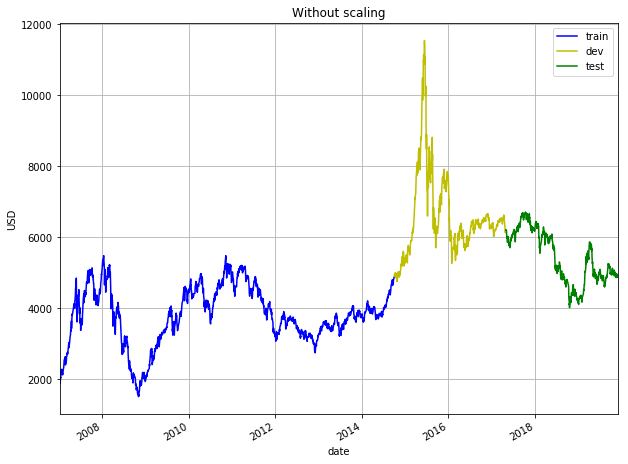

In [19]:
# Plot adjusted close over time
rcParams['figure.figsize'] = 10, 8 # width 10, height 8

ax = train.plot(x='date', y='adj_close', style='b-', grid=True)
ax = cv.plot(x='date', y='adj_close', style='y-', grid=True, ax=ax)
ax = test.plot(x='date', y='adj_close', style='g-', grid=True, ax=ax)
ax.legend(['train', 'dev', 'test'])
ax.set_xlabel("date")
ax.set_ylabel("USD")
ax.set_title("Without scaling")

Text(0.5, 1.0, 'With scaling')

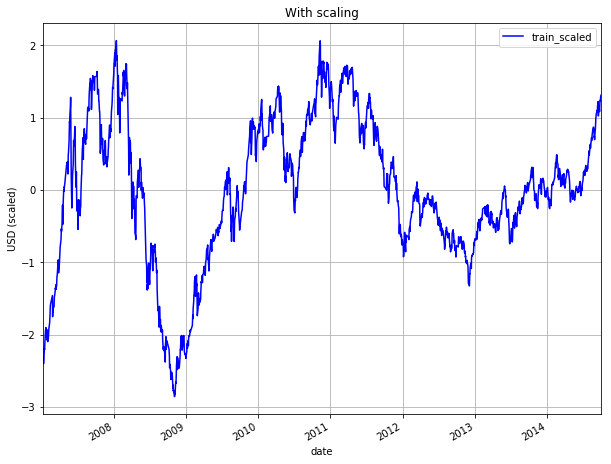

In [20]:
# Plot adjusted close over time
rcParams['figure.figsize'] = 10, 8 # width 10, height 8

ax = train_scaled.plot(x='date', y='adj_close', style='b-', grid=True)
ax.legend(['train_scaled'])
ax.set_xlabel("date")
ax.set_ylabel("USD (scaled)")
ax.set_title("With scaling")

# Train the model using lightGBM

In [23]:
import sys
sys.path.append('../')
sys.path.append('../../')
sys.path.append('../../../')
from src.stacking.models.m2_lgb import *
from src.conf.configuration import regress_conf

# load xgboost regression configuration
regress_conf.lgb_config_r()
regress_conf.cv_folds = None
regress_conf.early_stop_round = 1000
regress_conf.max_round = 10000

params = {'task': 'train',
          'boosting': 'gbdt',  # 设置提升类型
          'objective': 'regression',  # 目标函数
          'metric': {'l2', 'auc'},  # 评估函数
          'num_leaves': 31,  # 叶子节点数
          'learning_rate': 0.05,  # 学习速率
          'feature_fraction': 0.9,  # 建树的特征选择比例 # 样本列采样
          'bagging_fraction': 0.8,  # 建树的样本采样比例
          'bagging_freq': 5,  # k 意味着每 k 次迭代执行bagging
          'lambda_l1': 0.90,  # L1 正则化
          'lambda_l2': 0.95,  # L2 正则化
          'bagging_seed': 100,  # 随机种子,light中默认为100
          'verbosity': 1  # <0 显示致命的, =0 显示错误 (警告), >0 显示信息
}
regress_conf.params.update(params)

lgb_m = LightGBM(regress_conf)
best_score, best_round, best_model = lgb_m.fit(X_train_scaled.values, y_train_scaled.values)


2019-12-02 16:39:03,934 - ../../../src/stacking/models/m2_lgb.py[line:41] - INFO: NonCrossValidation。。。。
2019-12-02 16:39:04,489 - ../../../src/stacking/models/m2_lgb.py[line:61] - INFO: best_score: 
defaultdict(<class 'dict'>, {'training': {'auc': 0.9966841149601384, 'l2': 0.008736502840468363}, 'valid_1': {'auc': 0.9958690546925841, 'l2': 0.012583977526360948}})


In [26]:
# Do prediction on train set
est_scaled = lgb_m.predict(best_model ,X_train_scaled.values)
est = est_scaled * math.sqrt(scaler.var_[0]) + scaler.mean_[0]

# Calculate RMSE
print("RMSE on train set = %0.3f" % math.sqrt(mean_squared_error(y_train, est)))

# Calculate MAPE
print("MAPE on train set = %0.3f%%" % get_mape(y_train, est))

AttributeError: 'int' object has no attribute 'predit'

In [ ]:
# # Create the model
# from xgboost import XGBRegressor

# model = XGBRegressor(seed=model_seed,
#                      n_estimators=n_estimators,
#                      max_depth=max_depth,
#                      learning_rate=learning_rate,
#                      min_child_weight=min_child_weight,
#                      subsample=subsample,
#                      colsample_bytree=colsample_bytree,
#                      colsample_bylevel=colsample_bylevel,
#                      gamma=gamma)

# # Train the regressor
# model.fit(X_train_scaled, y_train_scaled)


# Predict on train set

In [ ]:
# # Do prediction on train set
# est_scaled = model.predict(X_train_scaled)
# est = est_scaled * math.sqrt(scaler.var_[0]) + scaler.mean_[0]

# # Calculate RMSE
# print("RMSE on train set = %0.3f" % math.sqrt(mean_squared_error(y_train, est)))

# # Calculate MAPE
# print("MAPE on train set = %0.3f%%" % get_mape(y_train, est))

In [ ]:
# Plot adjusted close over time
rcParams['figure.figsize'] = 10, 8 # width 10, height 8

est_df = pd.DataFrame({'est': est, 
                       'date': train['date']})

ax = train.plot(x='date', y='adj_close', style='b-', grid=True)
ax = cv.plot(x='date', y='adj_close', style='y-', grid=True, ax=ax)
ax = test.plot(x='date', y='adj_close', style='g-', grid=True, ax=ax)
ax = est_df.plot(x='date', y='est', style='r-', grid=True, ax=ax)
ax.legend(['train', 'dev', 'test', 'predictions'])
ax.set_xlabel("date")
ax.set_ylabel("USD")
ax.set_title('Without scaling')

# Predict on dev set

In [ ]:
# Do prediction on test set
est_scaled = xgb_m.predict(best_model, X_cv_scaled.values)
cv['est_scaled'] = est_scaled
cv['est'] = cv['est_scaled'] * cv['adj_close_std'] + cv['adj_close_mean']

# Calculate RMSE
rmse_bef_tuning = math.sqrt(mean_squared_error(y_cv, cv['est']))
print("RMSE on dev set = %0.3f" % rmse_bef_tuning)

# Calculate MAPE
mape_bef_tuning = get_mape(y_cv, cv['est'])
print("MAPE on dev set = %0.3f%%" % mape_bef_tuning)

In [ ]:
# Plot adjusted close over time
rcParams['figure.figsize'] = 10, 8 # width 10, height 8

est_df = pd.DataFrame({'est': cv['est'], 
                       'y_cv': y_cv,
                       'date': cv['date']})

ax = train.plot(x='date', y='adj_close', style='b-', grid=True)
ax = cv.plot(x='date', y='adj_close', style='y-', grid=True, ax=ax)
ax = test.plot(x='date', y='adj_close', style='g-', grid=True, ax=ax)
ax = est_df.plot(x='date', y='est', style='r-', grid=True, ax=ax)
ax.legend(['train', 'dev', 'test', 'predictions'])
ax.set_xlabel("date")
ax.set_ylabel("USD")

In [ ]:
# Plot adjusted close over time, for dev set only
rcParams['figure.figsize'] = 10, 8 # width 10, height 8
ax = train.plot(x='date', y='adj_close', style='b-', grid=True)
ax = cv.plot(x='date', y='adj_close', style='y-', grid=True, ax=ax)
ax = test.plot(x='date', y='adj_close', style='g-', grid=True, ax=ax)
ax = est_df.plot(x='date', y='est', style='r-', grid=True, ax=ax)
ax.legend(['train', 'dev', 'test', 'predictions'])
ax.set_xlabel("date")
ax.set_ylabel("USD")
ax.set_xlim([date(2018, 4, 20), date(2019, 2, 20)])

# ax.set_xlim([date(2014, 9, 20), date(2017, 5, 10)])
ax.set_title("Zoom in to dev set")

The predictions capture the turn in directions with a slight lag

Importance features dominated by adj_close and volume

# Final model

In [ ]:
# load xgboost regression configuration
regress_conf.xgb_config_r()
regress_conf.cv_folds = None
regress_conf.early_stop_round = 1000
regress_conf.max_round = 10000

param = {'base_score':0.5, 
         'booster':'gbtree', 
         'colsample_bylevel':1,
         'colsample_bynode':1, 
         'colsample_bytree':1, 
         'gamma':0,
         'importance_type':'gain',
         'learning_rate':0.1,
         'max_delta_step':0,
         'max_depth':3,
         'min_child_weight':1,
         'missing':None,
         'n_estimators':100,
         'n_jobs':1,
         'nthread':4,
         'objective':'reg:linear',
         'random_state':0,
         'reg_alpha':0,
         'reg_lambda':1,
         'scale_pos_weight':1,
         'seed':100,
         'subsample':1, 
         'verbosity':1
        }
regress_conf.params.update(param)

xgb_m = XGBooster(regress_conf)
best_score, best_round, best_model = xgb_m.fit(X_train_cv_scaled.values, y_train_cv_scaled.values )

In [ ]:
# Do prediction on train set
est_scaled = xgb_m.predict(best_model ,X_train_cv_scaled.values)
est = est_scaled * math.sqrt(scaler_train_cv.var_[0]) + scaler_train_cv.mean_[0]

# Calculate RMSE
print("RMSE on train set = %0.3f" % math.sqrt(mean_squared_error(X_train_cv, est)))

# Calculate MAPE
print("MAPE on train set = %0.3f%%" % get_mape(y_train_cv, est))

In [ ]:
# Plot adjusted close over time
rcParams['figure.figsize'] = 10, 8 # width 10, height 8

est_df = pd.DataFrame({'est': est, 
                       'date': train_cv['date']})

ax = train.plot(x='date', y='adj_close', style='b-', grid=True)
ax = cv.plot(x='date', y='adj_close', style='y-', grid=True, ax=ax)
ax = test.plot(x='date', y='adj_close', style='g-', grid=True, ax=ax)
ax = est_df.plot(x='date', y='est', style='r-', grid=True, ax=ax)
ax.legend(['train', 'dev', 'test', 'predictions'])
ax.set_xlabel("date")
ax.set_ylabel("USD")
ax.set_title('Without scaling')

In [ ]:
# Do prediction on test set
est_scaled = xgb_m.predict(best_model, X_sample_scaled.values)
test['est_scaled'] = est_scaled
test['est'] = test['est_scaled'] * test['adj_close_std'] + test['adj_close_mean']

# Calculate RMSE
rmse_bef_tuning = math.sqrt(mean_squared_error(y_sample, test['est']))
print("RMSE on test set = %0.3f" % rmse_bef_tuning)

# Calculate MAPE
mape_bef_tuning = get_mape(y_cv, cv['est'])
print("MAPE on test set = %0.3f%%" % mape_bef_tuning)

In [ ]:
# Plot adjusted close over time
rcParams['figure.figsize'] = 10, 8 # width 10, height 8

est_df = pd.DataFrame({'est': test['est'], 
                       'y_sample': y_sample,
                       'date': test['date']})

ax = train.plot(x='date', y='adj_close', style='b-', grid=True)
ax = cv.plot(x='date', y='adj_close', style='y-', grid=True, ax=ax)
ax = test.plot(x='date', y='adj_close', style='g-', grid=True, ax=ax)
ax = est_df.plot(x='date', y='est', style='r-', grid=True, ax=ax)
ax.legend(['train', 'dev', 'test', 'predictions'])
ax.set_xlabel("date")
ax.set_ylabel("USD")

In [ ]:
# Plot adjusted close over time, for test set only
rcParams['figure.figsize'] = 10, 8 # width 10, height 8
ax = train.plot(x='date', y='adj_close', style='b-', grid=True)
ax = cv.plot(x='date', y='adj_close', style='y-', grid=True, ax=ax)
ax = test.plot(x='date', y='adj_close', style='g-', grid=True, ax=ax)
ax = est_df.plot(x='date', y='est', style='r-', grid=True, ax=ax)
ax.legend(['train', 'dev', 'test', 'predictions'])
ax.set_xlabel("date")
ax.set_ylabel("USD")
ax.set_xlim([date(2017, 4, 20), date(2019, 11, 29)])
ax.set_ylim([4000, 6800])
ax.set_title("Zoom in to test set")

Similar to dev set, the predictions capture turns in direction with a slight lag

In [ ]:
# Plot adjusted close over time, only for test set
rcParams['figure.figsize'] = 50, 40 # width 10, height 8
matplotlib.rcParams.update({'font.size': 14})

ax = test.plot(x='date', y='adj_close', style='gx-', grid=True)
ax = est_df.plot(x='date', y='est', style='rx-', grid=True, ax=ax)
ax.legend(['test', 'predictions using xgboost'], loc='upper left')
ax.set_xlabel("date")
ax.set_ylabel("USD")
ax.set_xlim([date(2017, 4, 20), date(2019, 11, 29)])
ax.set_ylim([3944, 6730])

In [ ]:
# # Save as csv
# test_xgboost = est_df
# test_xgboost.to_csv("./out/test_xgboost.csv")

# Findings
* By scaling the features properly, we can get good results for our predictions
* RMSE and MAPE changed very little with hyperparameter tuning
* The final RMSE and MAPE for test set are 1.162 and 0.58% respectively